In [1]:
# 단어 벡터 가져오기
from gensim.models import Word2Vec

# 모델 파일 경로
model_file = "212223_word2vec.model"

# Word2Vec 모델 불러오기
model = Word2Vec.load(model_file)

# 단어 벡터 불러오기
word_vectors = model.wv

In [15]:
import pandas as pd
import numpy as np

df = pd.read_csv('샘플커뮤니티.csv')
df = df[['Word','year','Community']]
df.head()

,Word,year,Community
0,23_multiplayer_online_game,2023,Community 1
1,23_printer,2023,Community 1
2,23_ai_literacy,2023,Community 1
3,23_intelligent_support,2023,Community 1
4,23_ect,2023,Community 1


In [11]:
import pandas as pd
import re
from tqdm.notebook import tqdm
import numpy as np
import networkx as nx
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.community import greedy_modularity_communities
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
stops=set(stopwords.words('english')) # 불용어 설정
import warnings
warnings.filterwarnings('ignore')

# input_directory="C:/researchdata/input"
# output_directory="C:/researchdata/output"

class Product():
    def __init__(self,id:int, name:str, year:int, raw_gene:list):
        self.id=id
        self.name=name
        self.year=year
        self.raw_gene=raw_gene
        self.genotype=None
        self.taxon=None
        self.ancestor=None
        self.descendant=None
        self.ancestors=None
        self.descendants=None
    
# 두 객체의 유전자형의 코사인 유사도 구하는 함수    
def cosine_similarity(product_i,product_j):
    A=product_i.genotype
    B=product_j.genotype
    return dot(A, B)/(norm(A)*norm(B))

# Output Network list, product_list에 taxon 할당ㅡ 
# input : 제품 목록, 연도 목록, 임계값, 제품명 -> 네트워크 분석 시행
# 제품 간의 유사도를 계산하고, 임계값 이상인 경우에만 그래프에 엣지를 추가
# 그래프의 커뮤니티를 추출하고, 제품에 taxon 값을 할당
def Network(input_product_list,input_year_list,input_threshold,product_name,label_representation=True):
    # Output Network list 
    temp_network_list=[] # 네트워크 그래프들을 담을 리스트
    # color_list
    color_list=list(mcolors.BASE_COLORS) # 그래프 노드에 적용할 색상
    color_list+=list(mcolors.TABLEAU_COLORS)
    color_list+=list(mcolors.CSS4_COLORS)

    for year in tqdm(input_year_list):
        temp_title=str(product_name)+"_"+str(year)+"_"+str(input_threshold) # 결과 파일 이름 생성
        temp_products=[x for x in product_list if x.yera!="No"] # input_product_list에서 해당 연도와 일치하는 제품들로 구성
        #product_list -> input_product_list(?), yera -> year(?)
        temp_products=[x for x in temp_products if int(float(x.year))==year] # 해당 연도와 일치하는 제품들
        temp_G=nx.Graph() # 그래프 초기화
        for i in range(len(temp_products)): 
            temp_G.add_node(temp_products[i].name) # 노드 추가
            for j in range(i+1,len(temp_products)):
                if temp_products[i]!=temp_products[j]:
                    temp_weight=cosine_similarity(temp_products[i],temp_products[j])
                if temp_weight>=input_threshold: # 유사도 계산해 임계값 이상인 경우에만 그래프에 엣지 추가
                    temp_G.add_edge(temp_products[i].name,temp_products[j].name,weight=temp_weight)

        # Community Dictionary
        c=greedy_modularity_communities(temp_G) # 그래프의 커뮤니티 추출
        print(len(c))
        # Taxon Assign (커뮤니티에 속하는 제품들에 taxon 값 할당)
        for i in range(len(c)):
            for product in temp_products:
                if product.name in list(c[i]):
                    product.taxon=i 

        # Node 크기를 위한 dictionary
        d = nx.degree_centrality(temp_G)

        # Network Layout
        pos1=nx.spring_layout(temp_G)

        # 그래프 시각화
        plt.figure(figsize=(20,20))
        for i in range(len(c)):
            nx.draw_networkx_nodes(temp_G,pos=pos1,node_color=color_list[i],nodelist = list(c[i]), node_size = [d[n] * 1000 for n in list(c[i])])  
            if label_representation:
                nx.draw_networkx_labels(temp_G,pos=pos1,labels={n:n for n in list(c[i])},font_size=10,alpha=0.8,font_color=color_list[i])
            else:
                pass

        nx.draw_networkx_edges(temp_G,pos=pos1,alpha=0.5,edge_color="grey")
        #labels={n:n.name for n in temp_G.nodes}
        #nx.draw_networkx_labels(temp_G,pos=pos1,labels={n:n for n in temp_G.nodes},font_size=10,alpha=0.5)

        nx.write_edgelist(temp_G, temp_title+".txt", data=False,delimiter=",")
        nx.write_edgelist(temp_G, temp_title+"_weight.txt", data=["weight"],delimiter=",")
        plt.savefig(temp_title+".jpg",dpi=200,transparent=True,bbox_inches="tight")    
        temp_network_list.append(temp_G) # 그래프를 파일로 저장하고 temp_network_list에 그래프 추가

    return temp_network_list

# product를 csv로 추출
# 실제 코드 시에는 많이 소거해야 할 부분
def product_csv(input_product_list,temp_title):
    temp_result_df=pd.DataFrame()
    for product in tqdm(input_product_list):
        # 각 제품의 속성 추가, 이를 temp_result_df에 저장
        temp_list=[]
        ## 수정1
        ## title, keywords, year, community
        temp_list.append(product.id)
        temp_list.append(product.name)
        temp_list.append(product.year)
        temp_list.append(product.taxon)
        temp_list.append(product.genotype)
        temp_list.append(product.raw_gene)
        # 추가한 값들을 데이터프레임에 추가함.
        temp_result_df=temp_result_df.append(pd.Series(temp_list),ignore_index=True)
  
    temp_result_df.columns=["id","name","year","taxon","genotype","raw_gene"]
    temp_result_df.to_csv(str(temp_title)+'.csv',index=False)
    # product_genotype을 수직으로 쌓아 넘파이 배열로 저장
    # 1. temp_title을 문자열로 변환하여 파일 이름으로 사용합니다.
    # 2. input_product_list에 있는 각 제품의 genotype 속성을 가져와서 리스트 컴프리헨션을 사용하여 배열로 변환합니다.
    # 3. np.vstack 함수를 사용하여 배열들을 수직으로 쌓아 하나의 큰 배열을 생성합니다.
    # 4. np.save 함수를 사용하여 생성된 배열을 바이너리 파일로 저장합니다. 파일 이름은 temp_title로 지정
    np.save(str(temp_title),np.vstack([product.genotype for product in input_product_list]))


In [16]:
### after ###
df = pd.read_csv('샘플커뮤니티.csv')
df = df[['Word','year','Community']]

# 벡터값을 각 칼럼에 추가

# 각 단어의 벡터 표현 얻기
word_embeddings = []
for word in df['Word']:
    if word in word_vectors:
        word_embedding = word_vectors[word]
        word_embeddings.append(word_embedding)
    else:
        # 해당 단어의 벡터 표현이 없는 경우, 원하는 처리를 수행하세요.
        # 예를 들어, 벡터를 0 벡터로 초기화하거나, 다른 특정 값을 할당할 수 있습니다.
        word_embedding = [0.0] * model.vector_size
        word_embeddings.append(word_embedding)

# 벡터 표현을 DataFrame에 추가
embedding_dim = model.vector_size
embedding_columns = [f"embedding_{i+1}" for i in range(embedding_dim)]
embedding_df = pd.DataFrame(word_embeddings, columns=embedding_columns)
df = pd.concat([df, embedding_df], axis=1)

In [20]:
# 연속형 리스트
Continuous_var_list=[f"embedding_{i+1}" for i in range(embedding_dim)]

In [22]:
### 수행 o ###
# 각 변수에 대해 최소, 최대값 구하고 데이터에 대한 비율로 전환 (정규화?) - MinMaxScaler
# 연속형 변수에 대해서 정규화 시행
# 실제 코드에서는 시행하지 않을 사항
for Con_var in Continuous_var_list:
    temp_max=max(df[Con_var])
    temp_min=min(df[Con_var])
    temp_list=[]
    for index in range(len(df)):
        temp_list.append(float(df.loc[index,Con_var]/(temp_max-temp_min)))
    df[Con_var]=temp_list

df.head()

,Word,year,Community,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100
0,23_multiplayer_online_game,2023,Community 1,-0.001945,0.008375,-0.012771,-0.001748,-0.000747,-0.004330,-0.003274,...,0.002422,-0.003578,0.013629,-0.005958,0.008416,-0.001395,0.006163,0.008723,-0.000592,-0.004540
1,23_printer,2023,Community 1,0.000923,0.022221,-0.035976,0.021828,0.032135,-0.018952,-0.036102,...,-0.006308,-0.000653,0.022913,-0.019891,0.044979,-0.003854,0.003544,0.055180,-0.014338,0.011787
2,23_ai_literacy,2023,Community 1,0.019135,0.016784,-0.038441,-0.007731,0.011045,-0.008519,-0.020648,...,-0.002893,-0.005185,0.010056,-0.033410,0.022590,-0.009254,0.019938,0.037646,-0.014550,-0.001040
3,23_intelligent_support,2023,Community 1,0.003123,0.004489,-0.003981,0.000541,0.000026,-0.000907,-0.003666,...,-0.004936,0.001809,0.011430,-0.004632,0.008832,-0.005057,0.004992,0.005774,-0.001331,-0.001734
4,23_ect,2023,Community 1,0.005205,0.004796,-0.017120,0.000209,0.001620,-0.001938,-0.004602,...,-0.005871,0.000604,0.004507,-0.003428,0.012801,0.000576,0.004071,0.013270,0.000444,-0.000433


In [48]:
gene_dictionary_df = pd.DataFrame(df['Community'].unique())
gene_dictionary_df['index'] = 0
for i in range(len(gene_dictionary_df)):  
    gene_dictionary_df['index'][i] = i
gene_dictionary_df.columns = ['Category', 'index']
gene_dictionary_df.to_csv("word_gene_dict.csv",index=False, encoding='utf-8-sig')

In [12]:
df.head()

,Word,Community,year
0,23_multiplayer_online_game,Community 1,2023
1,23_printer,Community 1,2023
2,23_ai_literacy,Community 1,2023
3,23_intelligent_support,Community 1,2023
4,23_ect,Community 1,2023


In [35]:
product_list=[]

for i in range(len(df)):
    temp_id=i
    temp_name=df.loc[i,"Word"]
    temp_year=int(df.loc[i,"year"])
    
    temp_raw_gene=list(df.columns)[3:] # Name, Year 제외
    product_list.append(Product(temp_id,temp_name,temp_year,temp_raw_gene))
    
for i in range(len(product_list)):
    # 해당 제품의 genotype 속성 생성, 이를 Numpy 배열로 초기화
    product_list[i].genotype=np.array(df.loc[i][3:])

In [37]:
product_list[0]
# product_csv(product_list, "rifle_products")는 product_list에 있는 
# 제품 정보를 CSV 파일로 추출하는 함수인 product_csv를 호출
# rifle_products.csv, rifle_products.npy 생성
product_csv(product_list,"word_products")

  0%|          | 0/21697 [00:00<?, ?it/s]

In [38]:
# -*- coding: utf-8 -*-
"""Tree.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1aVf5DOYOhl_FwSwjVv4j7RlxZPW41nl4
"""

import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
from numpy import dot
from numpy.linalg import norm
import networkx as nx
from numpy import dot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from math import pi
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import pydot # graphviz를 파이썬에서 사용하기 편리하게, 그래프에서 시각화하기 편하게함.
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib import cm

In [39]:
# 특정 분류 나타내는 객체 생성위한 클래스
class TAXON():
    def __init__(self,id:int, name:str, year:int):
        self.id=id
        self.name=name
        self.year=year
        self.representative=None
        self.genes=None
        self.products=None
        self.genotype=None
        self.ancestor=None
        self.similarity=None
        self.ancestors=None
        self.descendants=None
        self.representative_vector=None
        self.innovativeness = None
        self.path_dependency = None
        self.btwnCent = None
        self.visit = None
# 트리노드 생성 클래스
class TreeNode():
    def __init__(self,input_taxon):
        self.taxon = input_taxon
        self.child = None
        self.pos=(None,None)

class Tree():
    def __init__(self, root: TreeNode) -> None:
        self.root = root # 트리 루트 설정
        self.pos={}
        self.count=0  
    # 노드 방문하여 출력하고 위치 (pos) 선정
    def visit(self, node: TreeNode, depth:int) -> None:
      #print("--"*depth, node.taxon.name)
        print("--"*depth, node.taxon.representative)
        self.pos[node]=(depth,self.count*10)
        self.count+=1
    # 깊이 우선 탐색을 사용하여 트리를 순회하며 노드 방문
    def __DFT_preorderHelp(self, curNode, depth:int)->None:
      #base case
        if curNode ==None:
            return
        self.visit(curNode, depth)

        #child
        for childNode in curNode.child :
            self.__DFT_preorderHelp(childNode, depth+1)


    def DFT_preorder(self) -> None:
        self.__DFT_preorderHelp(self.root, 0)

"""# Functions"""
# 코사인 유사도
def cosine_similarity(A,B):
    return dot(A, B)/(norm(A)*norm(B))
# 자카드 유사도
def jaccard_similarity(A,B):
    return len(set(A).intersection(set(B)))/len(set(A).union(set(B)))
# 벡터 A와 B, 그리고 범주형 변수(Categorical) 리스트를 인자로 받아 Gower 유사도를 계산
# 범주형 변수는 정수 형태로 표현, 연속형 변수는 실수로 표현
def Gower_similarity(A,B,Cat_list):
    temp_value=[]
  # Categorical Part : 범주형인 경우
    for i in range(len(Cat_list)):
        if A[i]==B[i]:
            temp_value.append(1)
        else:
            temp_value.append(0)
  # Continuous Part : 연속형인 경우
    for i in range(len(Cat_list),len(A)):
        temp_value.append(
             1-abs(A[i]-B[i])
        )
    return sum(temp_value)/len(temp_value)

In [45]:
"""# Rifle"""

vectors=np.load("word_products.npy",allow_pickle=True)
df["vector"]=list(vectors)

In [46]:
df['vector']

0        [-0.001945250281713805, 0.008374732096976395, ...
1        [0.0009228363744791495, 0.022220877304360537, ...
2        [0.019135439117906838, 0.016783930622218876, -...
3        [0.003122920974839923, 0.004488510798350318, -...
4        [0.005204872834816446, 0.004795980651732853, -...
                               ...                        
21692    [-0.0017825738852347479, -0.000279139183260549...
21693    [0.0016822154659631339, 0.003208257457470525, ...
21694    [-0.005130900518621999, -0.011363224760565782,...
21695    [0.0007589098780618334, -0.008720403481818725,...
21696    [-0.007924750178189839, -0.011894259185325629,...
Name: vector, Length: 21697, dtype: object

In [49]:
"""## Coloring"""
# 실제로는 사용 x 코드

# 220418
# 먼저 gene_dictionary_df를 불러옴
gene_dictionary_df=pd.read_csv("word_gene_dict.csv")
gene_dictionary_df


df["year"]=df["year"].astype(int)
df.head()

,Word,year,Community,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,embedding_100,vector
0,23_multiplayer_online_game,2023,Community 1,-0.001945,0.008375,-0.012771,-0.001748,-0.000747,-0.004330,-0.003274,...,-0.003578,0.013629,-0.005958,0.008416,-0.001395,0.006163,0.008723,-0.000592,-0.004540,"[-0.001945250281713805, 0.008374732096976395, ..."
1,23_printer,2023,Community 1,0.000923,0.022221,-0.035976,0.021828,0.032135,-0.018952,-0.036102,...,-0.000653,0.022913,-0.019891,0.044979,-0.003854,0.003544,0.055180,-0.014338,0.011787,"[0.0009228363744791495, 0.022220877304360537, ..."
2,23_ai_literacy,2023,Community 1,0.019135,0.016784,-0.038441,-0.007731,0.011045,-0.008519,-0.020648,...,-0.005185,0.010056,-0.033410,0.022590,-0.009254,0.019938,0.037646,-0.014550,-0.001040,"[0.019135439117906838, 0.016783930622218876, -..."
3,23_intelligent_support,2023,Community 1,0.003123,0.004489,-0.003981,0.000541,0.000026,-0.000907,-0.003666,...,0.001809,0.011430,-0.004632,0.008832,-0.005057,0.004992,0.005774,-0.001331,-0.001734,"[0.003122920974839923, 0.004488510798350318, -..."
4,23_ect,2023,Community 1,0.005205,0.004796,-0.017120,0.000209,0.001620,-0.001938,-0.004602,...,0.000604,0.004507,-0.003428,0.012801,0.000576,0.004071,0.013270,0.000444,-0.000433,"[0.005204872834816446, 0.004795980651732853, -..."


In [52]:
# Categorical_var_list=["UAction","Act","Type","Foldable","Bullpup"]
#Continuous_var_list=["Cal_mm","Cleng_mm","L_mm","FL_mm","W_kg","gr_n","feed_n","Mv_m","Bullpup","Maximum range_m","effective range_m","BL_mm"]
Continuous_var_list=[f"embedding_{i+1}" for i in range(embedding_dim)]
# Cat_list=Categorical_var_list
All_var_list = Continuous_var_list
Taxa_list=[]


for i in range(len(df)):
    temp_id=i
    temp_name=str(temp_id)
    temp_year=df.loc[i,"year"]
    temp_representative=df.loc[i,"Word"]
    # genotype
    temp_representative_vector=df.loc[i,"vector"]
    # TAXON 클래스 호출해서 추가
    Taxa_list.append(TAXON(temp_id,temp_name,temp_year))
    Taxa_list[-1].representative=temp_representative+"_"+str(temp_year)
    Taxa_list[-1].representative_vector=temp_representative_vector


Taxa_list[0].__dict__ # 첫번째 객체의 속성 확인 -> 해당 객체의 속성과 값들이 딕셔너리 형태로 출력

{'id': 0,
 'name': '0',
 'year': 2023,
 'representative': '23_multiplayer_online_game_2023',
 'genes': None,
 'products': None,
 'genotype': None,
 'ancestor': None,
 'similarity': None,
 'ancestors': None,
 'descendants': None,
 'representative_vector': array([-0.001945250281713805, 0.008374732096976395, -0.012770923368174272,
        -0.0017483880606987484, -0.0007470963192349897,
        -0.004329724236253017, -0.0032735490123178682,
        -0.000866513326807058, -0.012807363887767846,
        -0.0017375059447249732, -0.0056439019014633916,
        0.007002344000786745, 5.8308662329260506e-05,
        0.0005621459533149032, 0.007365224903264875, -0.00740637349360345,
        0.004578539427708969, -0.011311352224282522, -0.002544282493196006,
        -0.013512618061472102, 0.005778134773538802,
        -0.0007994349700770225, 0.006308765058065776,
        -0.015388497847608814, -1.333852757344806e-05,
        -0.002592582203764098, -0.006439293238216337,
        -0.00490540527693824

In [ ]:
### 실행 x ###
# 220418
# Taxa_list(사실은 그냥 단일 소총 제품)의 representative_vector의 3번째가 Type을 의미
# representative_vector의 3번째가 0이면 manual
# representative_vector의 3번째가 1,2이면 Auto, Semi-Auto
# TAXON 객체에 genes에 manual인지 Auto인지 정보를 assign

#Taxa_list[10].representative_vector[0]
# 조건에 따라 장르 추가 (사용 x) 
for taxon in Taxa_list:
    if taxon.representative_vector[0]==2:
        taxon.genes="breech_block"
    if taxon.representative_vector[0]==1:
        taxon.genes="bolt_action"
    if taxon.representative_vector[0]==3:
        taxon.genes="recoil"
    if taxon.representative_vector[0]==4:
        taxon.genes="lever_action"
    if taxon.representative_vector[0]==0:
        taxon.genes="Gas_operated"

In [54]:
#-------------------------------색을 작동방식으로
# 실제로는 칼럼명 변경해서 할 예정
df['Union'] = 0
for taxon in Taxa_list:
    # rifle.csv 파일에 대해서 시행
    for i in range(len(df)):
        if taxon.id == i:
            # rifle.csv파일의 Union칼럼의 값을 taxon의 products로 변형
            taxon.products=df.loc[i,'Union']
            print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119


3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760


5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401


6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041


8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683


10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310
1031

11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
1170

12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052
13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065
13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078
13079
13080
13081
13082
13083
13084
13085
13086
13087
13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
1310

14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431
14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442
14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455
14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468
14469
14470
14471
14472
14473
14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487
14488
14489
14490
14491
14492
14493
14494
14495
14496
1449

15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
15808
15809
15810
15811
15812
15813
15814
15815
15816
15817
15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844
15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858
15859
15860
15861
15862
15863
15864
15865
15866
15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879
15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893
15894
15895
15896
15897
15898
15899
15900
15901
15902
1590

17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
17160
17161
17162
17163
17164
17165
17166
17167
17168
17169
17170
17171
17172
17173
17174
17175
17176
17177
17178
17179
17180
17181
17182
17183
17184
17185
17186
17187
17188
17189
17190
17191
17192
17193
17194
17195
17196
17197
17198
17199
17200
17201
17202
17203
17204
17205
17206
17207
17208
17209
17210
17211
17212
17213
17214
17215
17216
17217
17218
17219
17220
17221
17222
17223
17224
17225
17226
17227
17228
17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
17258
17259
17260
17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
17274
17275
17276
17277
17278
17279
17280
17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302
17303
17304
17305
17306
17307
17308
17309
1731

18549
18550
18551
18552
18553
18554
18555
18556
18557
18558
18559
18560
18561
18562
18563
18564
18565
18566
18567
18568
18569
18570
18571
18572
18573
18574
18575
18576
18577
18578
18579
18580
18581
18582
18583
18584
18585
18586
18587
18588
18589
18590
18591
18592
18593
18594
18595
18596
18597
18598
18599
18600
18601
18602
18603
18604
18605
18606
18607
18608
18609
18610
18611
18612
18613
18614
18615
18616
18617
18618
18619
18620
18621
18622
18623
18624
18625
18626
18627
18628
18629
18630
18631
18632
18633
18634
18635
18636
18637
18638
18639
18640
18641
18642
18643
18644
18645
18646
18647
18648
18649
18650
18651
18652
18653
18654
18655
18656
18657
18658
18659
18660
18661
18662
18663
18664
18665
18666
18667
18668
18669
18670
18671
18672
18673
18674
18675
18676
18677
18678
18679
18680
18681
18682
18683
18684
18685
18686
18687
18688
18689
18690
18691
18692
18693
18694
18695
18696
18697
18698
18699
18700
18701
18702
18703
18704
18705
18706
18707
18708
18709
18710
18711
18712
18713
18714
1871

19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
19978
19979
19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993
19994
19995
19996
19997
19998
19999
20000
20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025
20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037
20038
20039
20040
20041
20042
20043
20044
20045
20046
20047
20048
20049
20050
20051
20052
20053
20054
20055
20056
20057
20058
20059
20060
20061
20062
20063
20064
20065
20066
20067
20068
20069
20070
20071
20072
20073
20074
20075
20076
20077
20078
20079
20080
20081
20082
20083
20084
20085
20086
20087
20088
20089
20090
20091
20092
20093
20094
20095
20096
20097
20098
20099
20100
20101
20102
20103
20104
20105
20106
20107
20108
20109
20110
20111
20112
20113
20114
20115
20116
20117
2011

21334
21335
21336
21337
21338
21339
21340
21341
21342
21343
21344
21345
21346
21347
21348
21349
21350
21351
21352
21353
21354
21355
21356
21357
21358
21359
21360
21361
21362
21363
21364
21365
21366
21367
21368
21369
21370
21371
21372
21373
21374
21375
21376
21377
21378
21379
21380
21381
21382
21383
21384
21385
21386
21387
21388
21389
21390
21391
21392
21393
21394
21395
21396
21397
21398
21399
21400
21401
21402
21403
21404
21405
21406
21407
21408
21409
21410
21411
21412
21413
21414
21415
21416
21417
21418
21419
21420
21421
21422
21423
21424
21425
21426
21427
21428
21429
21430
21431
21432
21433
21434
21435
21436
21437
21438
21439
21440
21441
21442
21443
21444
21445
21446
21447
21448
21449
21450
21451
21452
21453
21454
21455
21456
21457
21458
21459
21460
21461
21462
21463
21464
21465
21466
21467
21468
21469
21470
21471
21472
21473
21474
21475
21476
21477
21478
21479
21480
21481
21482
21483
21484
21485
21486
21487
21488
21489
21490
21491
21492
21493
21494
21495
21496
21497
21498
21499
2150

In [56]:
# 특정 taxon에 대해 단일 ancestor을 찾는 함수
# 유사도 비교, 가장 유사한 ancestor 반환
# descendant_taxon : 후손, 조상을 찾아야 할 대상
# 후손과 여러 개의 세습들의 유사도를 계산하고, 후손의 연도보다 이전에 있는 세습 중 가장 유사한 조상을 찾아 반환하는 함수
def Ancestor_Descendant_Single(descendant_taxon,taxa_list):
    # descendant_taxon의 연도(descendant_taxon.year)가 taxa_list에 있는 세습들의 연도 중 가장 작은 값인지 확인합니다. 만약 가장 작은 값이라면, 후손이 가장 오래된 세습이므로 조상을 찾을 수 없습니다. 
    # 따라서 None을 반환
    if descendant_taxon.year==min([taxon.year for taxon in taxa_list]):
        return None 
    else:
        temp_list=[]
        for taxon in taxa_list:
            # 세습의 연도(taxon.year)가 descendant_taxon의 연도보다 작은 경우
            if taxon.year < descendant_taxon.year:
                #temp_list.append(cosine_similarity(taxon.representative_vector,descendant_taxon.representative_vector))
                # 유사도를 계산하여 temp_list에 추가합니다.
                # Gower_similarity 함수 사용
                temp_list.append(Gower_similarity(taxon.representative_vector,descendant_taxon.representative_vector,Cat_list))
            else:
                # -1을 temp_list에 추가합니다. (후손보다 미래에 있는 세습의 유사도는 계산되지 않으므로 -1로 설정합니다.)
                temp_list.append(-1)
                # temp_list에서 가장 큰 값을 찾아 인덱스를 반환하여 해당 인덱스에 해당하는 조상(taxon)을 taxa_list에서 찾아 반환
        return taxa_list[temp_list.index(max(temp_list))]

# Matching Evolutionary Relationship
for taxon in tqdm(Taxa_list):
    # taxon의 조상을 Ancestor_Descendant_Single 함수로 찾음
    # 하나의 taxon, Taxa_list전체의 유사도를 계산해서 가장 유사한 조상 찾아 반환
    taxon.ancestor=Ancestor_Descendant_Single(taxon,Taxa_list)
    #taxon.ancestor=Ancestor_Descendant_Single(taxon,Taxa_list)

  0%|          | 0/21697 [00:00<?, ?it/s]

In [57]:
# 각 해당 Taxa_list의 후손 찾아서 저장
for ancestor in Taxa_list:
    temp_list=[]
    for descendant in Taxa_list:
        if descendant.ancestor==ancestor:
            temp_list.append(descendant) # 후손을 찾아서 리스트에 추가
    ancestor.descendants=temp_list

In [58]:
# 중복없는 연도 리스트
year_list=sorted(list(set(df["year"])))

temp_title="Rifle"

Root=TAXON(-1,"root",year_list[0]-1) # 루트 생성, ID는 -1, 이름은 root, 연도는 첫번째 연도보다 1 작은 값으로 설정
Root.representative="root" 
t_root = TreeNode(Root) # 루트를 기반으로 트리 루트 노드 생성

Node_list=[]
for taxon in Taxa_list:
    # 각 taxon을 기반으로 트리 노드 생성, Node_list에 추가
    Node_list.append(TreeNode(taxon)) 

temp_list=[]
for Node in Node_list:
    # 첫번째 연도와 동일한 연도를 가진 노드를 찾아 임시 리스트에 추가
    if Node.taxon.year==year_list[0]:
        temp_list.append(Node) 
# 트리의 루트 노드의 자식 노드로서 첫번째 연도와 동일한 연도를 가진 노드들 생성
# 트리의 루토 노드의 자식 노드로 설정
t_root.child=temp_list 
# 루트 노드를 'Node_list'의 첫번째 연도와 동일한 연도를 가진 노드 설정
# Node_list 첫번째 노드에 루트 노드 삽입
Node_list.insert(0,t_root) 

for Node in tqdm(Node_list):
    # 현재 노드의 세습(taxon)의 연도가 첫 번째 연도보다 크거나 같은 경우
    if Node.taxon.year>=year_list[0]:
        Node.child=[]
        # 현재 노드의 세습의 후손(descendants)을 반복하면서 Node_list의 노드와 비교하여 후손과 일치하는 노드를 찾고
        # 해당 노드를 현재 노드의 자식으로 추가합니다.
        for descendant in Node.taxon.descendants:
            for Node_j in Node_list:
                if descendant.name==Node_j.taxon.name:
                    Node.child.append(Node_j) # 노드의 후손들과 Node_list를 비교하여 자식 노드를 찾고, Node.child에 추가

# myTree는 t_root를 루트로 하는 트리(Tree)의 인스턴스를 생성합니다.
# myTree.DFT_preorder()는 생성된 트리의 전위 순회를 수행하여 트리를 탐색하고, 각 노드를 출력합니다.                    
myTree = Tree(t_root) # 생성된 트리의 인스턴스 생성
myTree.DFT_preorder() # 트리의 전위 순회를 수행해 트리를 탐색, 각 노드 출력

  0%|          | 0/21698 [00:00<?, ?it/s]

 root
-- 23_multiplayer_online_game_2023
-- 23_printer_2023
-- 23_ai_literacy_2023
-- 23_intelligent_support_2023
-- 23_ect_2023
-- 23_predict_2023
-- 23_secure_programming_2023
-- 23_interactive_simulation_2023
-- 23_open_source_2023
-- 23_worm_2023
-- 23_intruder_2023
-- 23_hybrid_game_2023
-- 23_aerial_vehicle_2023
-- 23_proof_of_stake_2023
-- 23_covid_2023
-- 23_sketching_2023
-- 23_economic_growth_2023
-- 23_collision_warning_2023
-- 23_misbehavior_2023
-- 23_stylometry_2023
-- 23_metal_detector_2023
-- 23_computer_assisted_diagnosis_2023
-- 23_collaborative_editing_2023
-- 23_privacy_leakage_2023
-- 23_teaching_evaluation_2023
-- 23_sanitization_2023
-- 23_early_warning_2023
-- 23_case_base_2023
-- 23_motion_sensor_2023
-- 23_soundscapes_2023
-- 23_can_bus_2023
-- 23_listed_company_2023
-- 23_time_sharing_2023
-- 23_business_2023
-- 23_uncertain_environment_2023
-- 23_security_concern_2023
-- 23_stream_processing_2023
-- 23_control_center_2023
-- 23_secure_software_2023
-- 23_ima

In [61]:
myTree.DFT_preorder()

 root
-- 23_multiplayer_online_game_2023
-- 23_printer_2023
-- 23_ai_literacy_2023
-- 23_intelligent_support_2023
-- 23_ect_2023
-- 23_predict_2023
-- 23_secure_programming_2023
-- 23_interactive_simulation_2023
-- 23_open_source_2023
-- 23_worm_2023
-- 23_intruder_2023
-- 23_hybrid_game_2023
-- 23_aerial_vehicle_2023
-- 23_proof_of_stake_2023
-- 23_covid_2023
-- 23_sketching_2023
-- 23_economic_growth_2023
-- 23_collision_warning_2023
-- 23_misbehavior_2023
-- 23_stylometry_2023
-- 23_metal_detector_2023
-- 23_computer_assisted_diagnosis_2023
-- 23_collaborative_editing_2023
-- 23_privacy_leakage_2023
-- 23_teaching_evaluation_2023
-- 23_sanitization_2023
-- 23_early_warning_2023
-- 23_case_base_2023
-- 23_motion_sensor_2023
-- 23_soundscapes_2023
-- 23_can_bus_2023
-- 23_listed_company_2023
-- 23_time_sharing_2023
-- 23_business_2023
-- 23_uncertain_environment_2023
-- 23_security_concern_2023
-- 23_stream_processing_2023
-- 23_control_center_2023
-- 23_secure_software_2023
-- 23_ima

TypeError: object of type 'NoneType' has no len()

In [59]:
## 그래프를 생성하고, 그래프의 노드 간 연결을 정의하며, 그래프에서 중간 중심성을 계산하여 노드의 크기를 설정하는 과정을 수행
# 그래프를 생성하고, 노드 간의 연결을 설정하여 그래프를 구성합니다. 그래프에서 중간 중심성을 계산하여 노드의 크기를 설정할 수 있습니다. 
# 중간 중심성은 그래프에서 어떤 노드가 다른 노드들 간의 최단 경로상에서 얼마나 중요한 역할을 하는지를 측정하는 지표
# 이를 기준으로 노드의 크기를 결정하여 중요한 노드를 시각적으로 강조할 수 있습니다.
G=nx.DiGraph() # 방향 그래프 생성
# 초기 임계값 : 0
temp_threshold=0
for node in Node_list:
    G.add_node(node.taxon.name) # 각 노드에 대해 그래프에 노드 추가 (node.taxon.name : 노드의 이름)
    # 노드가 자식을 가지고 있다면?
    if node.child:
        # 해당 자식 노드를 그래프에 추가, 부모와 자식 노드 사이 엣지 추가 -> ancestor, taxon 관계 그래프로 표현
        for temp_child in node.child:
            # 각 노드의 세습(taxon) 이름을 그래프(G)에 노드로 추가
            G.add_node(temp_child.taxon.name)
            # 각 자식 노드를 그래프(G)에 노드로 추가
            G.add_edge(node.taxon.name,temp_child.taxon.name)

temp_node_list = list(G.nodes) # 그래프의 모든 노드 저장
# 그래프에서 노드의 중간 중심성 계산
btwnCent = nx.betweenness_centrality(G, normalized=True, endpoints=False)
# 중간중심성 값을 기준으로 노드를 내림차순으로 결정
sorted_nodes = sorted(btwnCent.items(), key=lambda x:x[1], reverse=True)


In [64]:
product_df = pd.read_csv("word_products.csv", encoding='cp949')

In [66]:
# 임시 리스트 초기화
temp_name_list = []
temp_btwn_list = []
temp_id_list = []
# 정렬된 노드의 이름과 중간 중심성 값을 기반으로 해당 정보를 임시 리스트에 추가, 이 때 root 노드는 제외
for k in range(len(sorted_nodes)):
    # root노드가 아닐때 (시작 노드가 아닐 때)
    if sorted_nodes[k][0] != 'root':
        for i in range(len(product_df)):
            if int(product_df['id'][i]) == int(sorted_nodes[k][0]):
                temp_name_list.append(product_df['name'][i])
                temp_id_list.append(int(product_df['id'][i]))
                temp_btwn_list.append(sorted_nodes[k][1])

# 임시 리스트를 활용하여 temp_df를 생성하고, 열 이름과 해당 정보 할당
temp_df=pd.DataFrame()
temp_df['id'] = temp_id_list
temp_df['name'] = temp_name_list
temp_df['btwn'] = temp_btwn_list
#bt_list = betweeness centrality for setting node size (노드 크기 설정위한 임시리스트)
bt_list = []

# 임시 리스트 'temp_node_list'의 각 노드에 대해 중간 중심성 값을 기반으로 크기 설정, bt_list에 추가, root노드의 크기는 1로 설정
for i in range(len(temp_node_list)):
    if temp_node_list[i] != 'root':
        for j in range(len(temp_df)):
            # temp_df 데이터프레임을 순회하면서 현재 노드의 ID와 일치하는 행을 찾습니다.
            if int(temp_node_list[i]) == int(temp_df['id'][j]):
                # 일치하는 행의 'btwn' 열의 값에 5000을 곱하고 1을 더하여 크기를 설정
                # ? 굳이 왜 5000을 곱했을까요...?
                bt_list.append(5000*(temp_df['btwn'][j])+1)
    else :
        bt_list.append(1)



In [67]:
year_name = {}
for i in range(len(Taxa_list)):
    year_name[Taxa_list[i].name] = Taxa_list[i].year
# 이 연도는 실제 반영시 수정 예정
year_name['root'] = 2023
Taxa_list[0].genes

In [69]:
# 진화 트리(phylogenetic tree)를 그리는 함수인 phylogenetic_tree_Single을 구현
# 1. input_G는 입력 그래프를 나타냅니다.
# 2. input_Node_list는 노드 리스트를 나타냅니다.
# 3. input_style은 그래프에서 선을 그릴 때 사용할 스타일을 정의합니다.
# 4. input_lw는 그래프에서 선의 두께를 정의합니다.
# 5. input_temp_title은 생성된 그래프의 제목을 나타냅니다.
# 6. name_mode는 노드의 이름을 표시할지 대표값을 표시할지를 결정합니다.
# 7. input_labels_list는 표시할 라벨을 나타냅니다.
def phylogenetic_tree_Single(input_G,input_Node_list,input_style,input_lw,input_temp_title,name_mode,input_labels_list):
    pos1=graphviz_layout(input_G, prog="dot",root='root') # 그래프 레이아웃 설정
    #pos1=graphviz_layout(input_G, prog="twopi",root='root')
    temp_pos=pos1
    print(temp_pos)
    # 빈 딕셔너리로 초기화
    pos1={}
    for key in list(temp_pos.keys()):
        # 각 노드 위치 설정
        pos1[key]=[0,0] # 노드의 이름을 키로 가짐, 해당 노드의 좌표를 값으로 가짐
        pos1[key][0]=(temp_pos[key][0])  
        #pos1[key][index] : key의 x좌표와 y좌표를 나타냄. 여기서 [key][1]
        #pos1[key][1]=(year_name[key])
        pos1[key][1]=(-temp_pos[key][1]) # temp_pos : graphviz_layout 함수를 통해 어은 좌표 정보를 저장한 변수
    fig = plt.figure(figsize=(18,10))
    ax=plt.subplot(111)
    
    # root node의 후손 연결해주기
    for temp_child in input_Node_list[0].child:
        temp_edge=(input_Node_list[0].taxon.name,temp_child.taxon.name)
        # 선조, 후손 노드 연결하는 선 그림, 선을 그릴 위치, 스타일을 정함
        ax.annotate("",
                  xy=(pos1[temp_child.taxon.name][0],pos1[temp_child.taxon.name][1]),
                  xytext=(pos1[input_Node_list[0].taxon.name][0],pos1[input_Node_list[0].taxon.name][1]),
                  arrowprops=dict(
                                arrowstyle="-",  
                                lw=input_lw,
                                connectionstyle=input_style,
                                linewidth = 0.01,
                                #arrowstyle="wedge",
                                color="blue",
                                alpha=1
                                )
                      )

    # root node이외의 선조 후손 관계 연결   
    for node in input_Node_list:
        if node.taxon.name!="root":
            if node.taxon.descendants:
                for descendant in node.taxon.descendants :
                  # coloring : 220418 후손 제품이 manual이면 파랑, Auto면 빨강
                    print(descendant.representative," : ", descendant.genes)
                    ''' 
                  # coloring : Type에 따른 분류
                  if "Auto" == descendant.genes : 
                      temp_color = "royalblue"
                  elif "Semi-Auto" == descendant.genes : 
                      temp_color = "cadetblue"
                  elif "manual" == descendant.genes : 
                      temp_color = "aqua"
                  '''
                    if node.taxon.ancestor != None:
                        node.taxon.similarity = Gower_similarity(node.taxon.representative_vector,node.taxon.ancestor.representative_vector,Cat_list)

          # coloring 작동방식에 의한 분류
            # 실제에서는 사용하지 않는 부분 (총이기 때문에)
                    # 장르에 따른 색상 지정
#                     if "bolt_action" == descendant.genes:
#                           temp_color="blue"
#                     elif "lever_action" == descendant.genes:
#                           temp_color="deepskyblue"
#                     elif "recoil" == descendant.genes:
#                           temp_color = "Orange"
#                     elif "breech_block" == descendant.genes:
#                           temp_color = "aqua"
#                     elif "Gas_operated" == descendant.genes:
#                           temp_color="red"
#                     else :
#                           temp_color = "black"
          


                    temp_edge=(node.taxon.name,descendant.name)
                    ax.annotate("",
                    xy=(pos1[descendant.name][0],pos1[descendant.name][1]),
                    xytext=(pos1[node.taxon.name][0],pos1[node.taxon.name][1]),
                    arrowprops=dict(
                                        arrowstyle="-",  
                                        lw = input_lw,
                                        connectionstyle=input_style,
                                        color=temp_color,
                                        alpha=1
                                        )
                              )

    # 상하좌우 축 안보이게 설정
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False) # 축의 경계를 제거하여 차트의 외곽 경계를 깔끔하게
    # 범례를 생성하기 위해 사용하는 코드
    # 여기서도 labels은 한두개로 축소
    from matplotlib.lines import Line2D 
#     labels = ['bolt_action', 'lever_action',  'breech_block', 'recoil','Gas_operated']
#     colors = ['blue', 'deepskyblue',  'aqua','Orange', 'red']
#     legend_elements = [Line2D([0], [0], color=color, lw=2, label=label) for label, color in zip(labels, colors)]
#     ax.legend(handles=legend_elements) # 범례 그래프에 추가

  # color bar
  # labeling  
    if name_mode:
        for node in input_Node_list:  
            if node.taxon.name!="root":
                # 노드의 이름 또는 대표값을 그래프 상에 텍스트로 표시
                ax.text(pos1[node.taxon.name][0],pos1[node.taxon.name][1],node.taxon.name,rotation=30,fontsize=5)
        plt.tight_layout()
        plt.savefig(input_temp_title+"_Phylogenetic Tree dot inverse_200_wo_label.jpg",dpi=200,transparent=True,bbox_inches="tight")
        plt.savefig(input_temp_title+"_Phylogenetic Tree dot inverse_300_wo_label.jpg",dpi=300,transparent=True,bbox_inches="tight")
    else:
    # labeling  
        for node in input_Node_list:
            if node.taxon.name!="root":
            # input_labels_list
                if node.taxon.name in input_labels_list:
                    ax.text(pos1[node.taxon.name][0],pos1[node.taxon.name][1],node.taxon.representative,rotation=30,fontsize=5)
        
        # 노드와 라벨을 그래프에 그림
        nx.draw_networkx_labels(G,pos=pos1,labels={"root":"Root"},font_size=5,font_weight="bold")
    # 노드 그리기
    nx.draw_networkx_nodes(input_G,pos=pos1,node_color="black",nodelist = temp_node_list, node_size = bt_list, alpha=1)
    nx.draw_networkx_nodes(input_G,pos=pos1,node_color="black",nodelist=["root"],alpha=1)
  
    # 차트 여백 최적화, 그래프 이미지 파일로 저장
    # dpi에 따라서 파일 다르게 저장
    plt.tight_layout()
    plt.savefig(input_temp_title+"type_Phylogenetic Tree dot inverse_200_w_label.jpg",dpi=200,transparent=True,bbox_inches="tight")
    plt.savefig(input_temp_title+"type_Phylogenetic Tree dot inverse_300_w_label.jpg",dpi=300,transparent=True,bbox_inches="tight")

{'root': (817420.0, 90.0), '0': (27.0, 18.0), '1': (99.0, 18.0), '2': (171.0, 18.0), '3': (243.0, 18.0), '4': (315.0, 18.0), '5': (387.0, 18.0), '6': (459.0, 18.0), '7': (531.0, 18.0), '8': (603.0, 18.0), '9': (675.0, 18.0), '10': (747.0, 18.0), '11': (819.0, 18.0), '12': (891.0, 18.0), '13': (963.0, 18.0), '14': (1035.0, 18.0), '15': (1107.0, 18.0), '16': (1179.0, 18.0), '17': (1251.0, 18.0), '18': (1323.0, 18.0), '19': (1395.0, 18.0), '20': (1467.0, 18.0), '21': (1539.0, 18.0), '22': (1611.0, 18.0), '23': (1683.0, 18.0), '24': (1755.0, 18.0), '25': (1827.0, 18.0), '26': (1899.0, 18.0), '27': (1971.0, 18.0), '28': (2043.0, 18.0), '29': (2115.0, 18.0), '30': (2187.0, 18.0), '31': (2259.0, 18.0), '32': (2331.0, 18.0), '33': (2403.0, 18.0), '34': (2475.0, 18.0), '35': (2547.0, 18.0), '36': (2619.0, 18.0), '37': (2691.0, 18.0), '38': (2763.0, 18.0), '39': (2835.0, 18.0), '40': (2907.0, 18.0), '41': (2979.0, 18.0), '42': (3051.0, 18.0), '43': (3123.0, 18.0), '44': (3195.0, 18.0), '45': (32

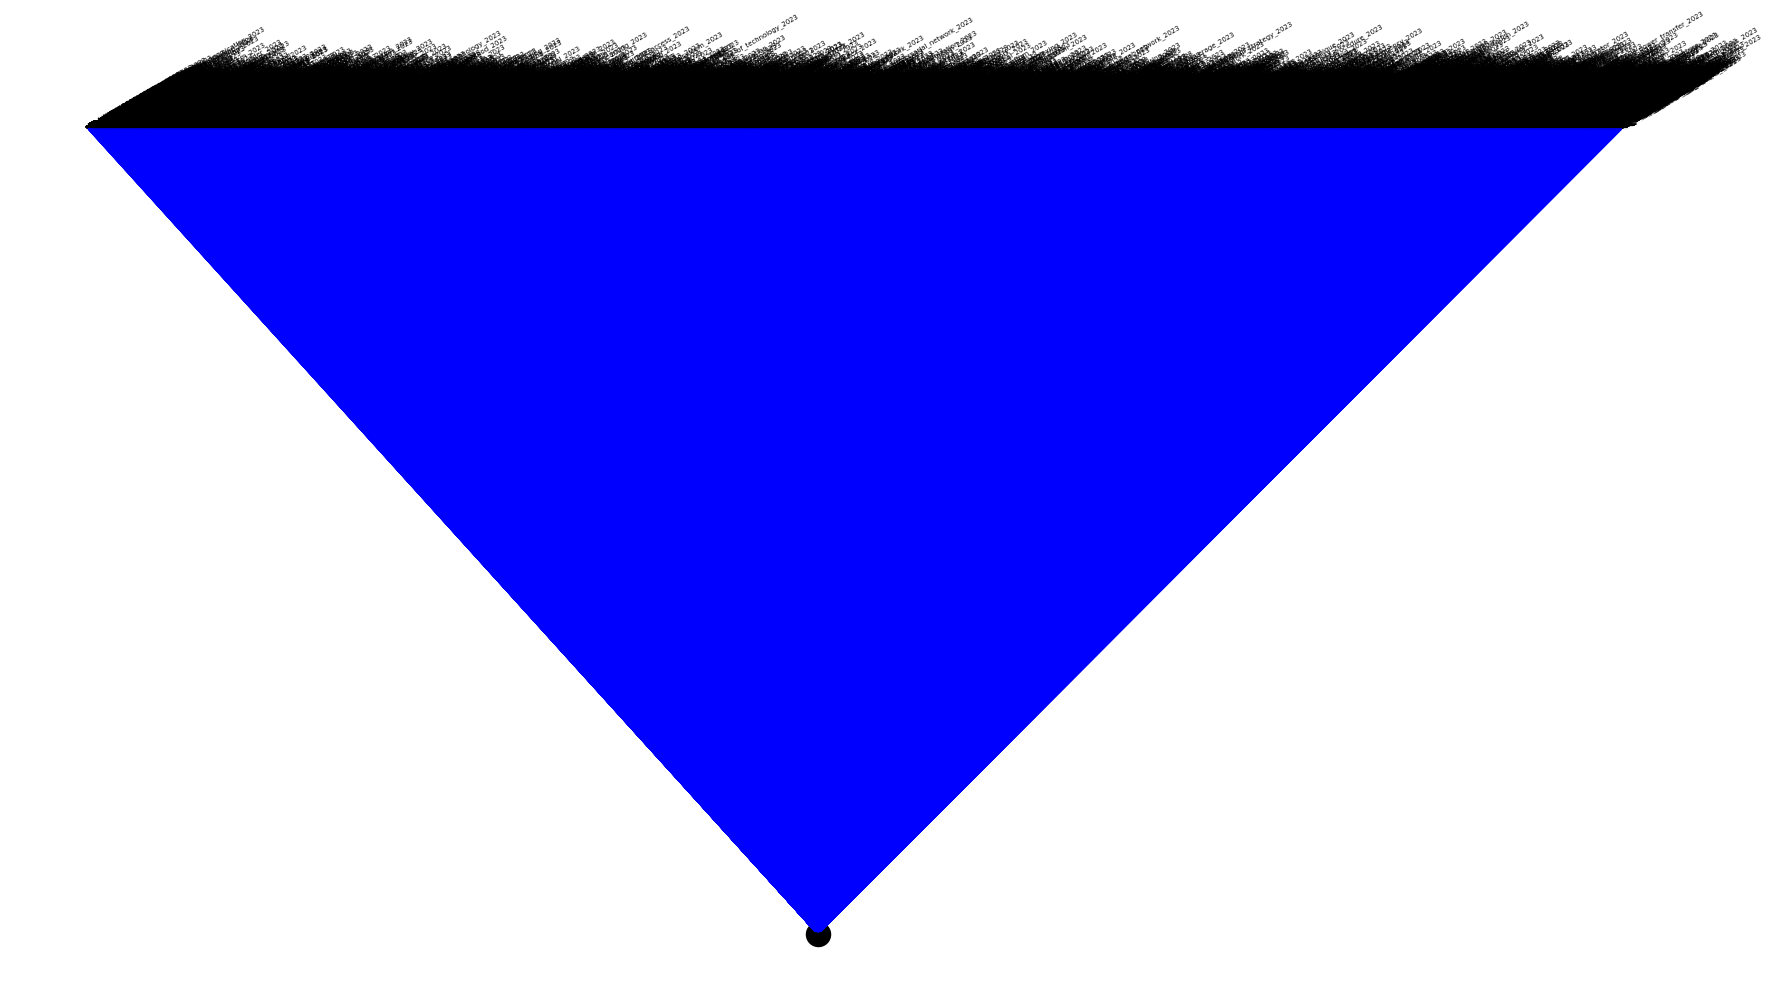

In [70]:
temp_lw=1.5
# phylogenetic_tree_Single 함수를 호출해 진화 트리를 그림 - G:그래프, Node_list:노드 리스트, arc3:선 스타일, temp_lw:선 두께,period:제목, False:라벨여부
phylogenetic_tree_Single(G,Node_list,"arc3",temp_lw,"period",False,[taxon.name for taxon in Taxa_list])